
## Driverless AI Python Client Tutorial with Lending Club Data


**Lending Club** publishes loan data periodically for public use. The anonymized data has information on different loans issued, such as loan_id, loan_amount, what loan grade, credit score etc., and also a **loan_status** variable that indicates whether a loan was _Fully Paid_ or _Charged Off_ (written off because of default).

In this tutorial, we use a python client to download the data from **Lending Club** website. The code then does some basic munging using Pandas, makes a connection to Driverless AI instance and then initiates a binary classification experiment using some inital experiment settings. In that process, we will also drop some target leakage columns, specify the target column, accuracy, time and interpretability settings, scorer etc.,

Before running the experiment, the data is split to training and test. At the end of the experiment, the test predictions and other model artifacts are then downloaded along with the model score (we are using AUC in this case). 


The first thing to do is to get the Driverless AI python client by following the steps here (if you don't have it already!)

http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/python_install_client.html

In [1]:
import h2oai_client
import numpy as np
import pandas as pd

import requests
import math
from sklearn import model_selection
from h2oai_client import Client, ModelParameters, InterpretParameters

#### Connect to Driverless AI instance 

Replace the <driverless_ai_host> with the correct IP address of the driverless AI instance. Make sure there is no firewall blocking the 12345 port. The username and password should be the same as what you'd use to login to Driverless AI instance.


In [2]:
# Let's connect to the Driverless AI instance

address = 'http://<driverless_ai_host>:12345'
username = '<username>'  
password = '<password>'
h2oai = Client(address = address, username = username, password = password)

# make sure to use the same user name and password when signing in through the GUI

#### Download 2007-2011 Loan Data from Lending Club Website

The url provided in the wget command is where the 2007-2011 loan data is. You can also loan data over different periods from https://www.lendingclub.com/info/download-data.action

To look at the data dictionary of the different columns, click here: 
https://resources.lendingclub.com/LCDataDictionary.xlsx

In [3]:
!wget "https://resources.lendingclub.com/LoanStats3a.csv.zip"

--2019-03-08 02:04:22--  https://resources.lendingclub.com/LoanStats3a.csv.zip
Resolving resources.lendingclub.com (resources.lendingclub.com)... 64.48.1.20
Connecting to resources.lendingclub.com (resources.lendingclub.com)|64.48.1.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘LoanStats3a.csv.zip’

    [                   <=>                 ] 9,610,863    950KB/s   in 11s    

2019-03-08 02:04:34 (816 KB/s) - ‘LoanStats3a.csv.zip’ saved [9610863]



#### Munging the data in Pandas

We first read the data into a Pandas data frame. We skip reading the very first row as it has some non-header information. The target column **loan_status** has really 4 unique values, but as you can see below, it makes sense to fold them to 2 unique possibilities, **Fully Paid** and **Charged Off**, that makes it into a binary classification problem.

In [4]:
# Very first row has non-header data and hence skipping it. Read to a data frame

lc = pd.read_csv("LoanStats3a.csv.zip", low_memory=False, skiprows=1) 


In [5]:
# Normalize target column values for a simple binary classification problem

lc['loan_status'] = np.where(lc['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', lc['loan_status'])
lc['loan_status'] = np.where(lc['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'Charged Off', lc['loan_status'])

# Let's look at the unique values for the target col. Yes - it's a binary classification problem
lc.loan_status.unique()

array(['Fully Paid', 'Charged Off', nan], dtype=object)

#### Split to Train and Test - 80%/20%  and write it to two CSV files

In [20]:
import csv
train_lc, test_lc = model_selection.train_test_split(lc, test_size=0.2)
train_lc.to_csv("/tmp/train_lc.csv", index=False)
test_lc.to_csv("/tmp/test_lc.csv", index=False)

# View the top few rows with header
train_lc.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
42362,NaN,NaN,9950.0,9950.0,2175.0,36 months,12.80%,334.30,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2161,NaN,NaN,8400.0,8400.0,8125.0,60 months,8.90%,173.97,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4890,NaN,NaN,12800.0,12800.0,12800.0,60 months,23.52%,364.68,G,G3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
32816,NaN,NaN,5000.0,5000.0,5000.0,36 months,13.92%,170.69,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3925,NaN,NaN,35000.0,35000.0,34750.0,60 months,19.03%,908.50,E,E2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


#### Upload the Train and Test data to Driverless AI

In [22]:
train_path = "/tmp/train_lc.csv"
test_path = "/tmp/test_lc.csv"

train = h2oai.create_dataset_sync(train_path)
test = h2oai.create_dataset_sync(test_path)

In [23]:
# Check the shape of the data

print('Train Dataset: ', len(train.columns), 'x', train.row_count)
print('Test Dataset: ', len(test.columns), 'x', test.row_count)

Train Dataset:  145 x 34030
Test Dataset:  145 x 8508


In [24]:
# List of training columns (should be same for test data also) for sanity
[c.name for c in train.columns]

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

#### Run an Experiment Preview 
Set the target col to **loan_status**, dropped cols to the list of target leakage cols + accuracy, time and interpretability settings of 1,1 and 8. Let's set the scorer to AUC etc., The resulting output will be the execution plan for the experiment, including algorithm selections, cross validation strategy, feature transformations that will be used as decided by the recipe.

In [29]:
target='loan_status'
exp_preview = h2oai.get_experiment_preview_sync(dataset_key= train.key, 
                                                validset_key='', 
                                                classification=True, 
                                                # All dropped cols are target leakage cols
                                                dropped_cols = ['inq_last_6mths', 
                                                                'out_prncp', 
                                                                'out_prncp_inv', 
                                                                'total_pymnt', 
                                                                'total_pymnt_inv', 
                                                                'total_rec_prncp', 
                                                                'total_rec_int', 
                                                                'total_rec_late_fee', 
                                                                'recoveries', 
                                                                'collection_recovery_fee', 
                                                                'last_pymnt_d', 
                                                                'last_pymnt_amnt', 
                                                                'next_pymnt_d', 
                                                                'last_credit_pull_d'] , 
                                                target_col=target, 
                                                is_time_series = False, 
                                                enable_gpus = True, 
                                                accuracy = 1, time = 1, interpretability = 8, 
                                                config_overrides = None)
exp_preview

['ACCURACY [1/10]:',
 '- Training data size: *34,030 rows, 42 cols*',
 '- Feature evolution: *[LightGBM, XGBoost, GLM]*, *1/3 validation split*',
 '- Final pipeline: *[LightGBM, XGBoost, GLM]*',
 '',
 'TIME [1/10]:',
 '- Feature evolution: *2 individuals*, up to *3 iterations*',
 '- Early stopping: disabled',
 '',
 'INTERPRETABILITY [8/10]:',
 '- Feature pre-pruning strategy: FS',
 '- XGBoost Monotonicity constraints: enabled',
 '- Feature engineering search space (where applicable): [Date, FrequencyEncoding, Identity, Interactions, IsHoliday, NumEncoding, OneHotEncoding, TargetEncoding, Text, WeightOfEvidence]',
 '',
 '[LightGBM, XGBoost, GLM] models to train:',
 '- Model and feature tuning: *2*',
 '- Feature evolution: *3*',
 '- Final pipeline: *1*',
 '',
 'Estimated runtime: *minutes*']

#### Run the Experiment 
Let's set the accuracy, time and interpretability settings of 1,1 and 8. Also drop the target leakage columns and set the scorer to AUC and make it a classification problem. We are also passing on the training and test data references to the python API which we uploaded a few steps before. 

Feel free to increase the the settings with higher accuracy and time. Lowering the interpretability will increase feature engineering efforts to get a better model!

In [30]:

experiment = h2oai.start_experiment_sync(dataset_key=train.key,
                                         testset_key = test.key,
                                         target_col=target,
                                         is_classification=True,
                                         accuracy=1,
                                         time=1,
                                         interpretability=8,
                                         scorer="AUC",
                                         enable_gpus=True,
                                         seed=1234,
                                         # drop the target leakage cols
                                         cols_to_drop=['inq_last_6mths', 
                                                        'out_prncp', 
                                                        'out_prncp_inv', 
                                                        'total_pymnt', 
                                                        'total_pymnt_inv', 
                                                        'total_rec_prncp', 
                                                        'total_rec_int', 
                                                        'total_rec_late_fee', 
                                                        'recoveries', 
                                                        'collection_recovery_fee', 
                                                        'last_pymnt_d', 
                                                        'last_pymnt_amnt', 
                                                        'next_pymnt_d', 
                                                        'last_credit_pull_d'
                                                        ]
                                        )

#### Print Validation (from Training/Cross Validation) and Test Scores

In [31]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.702
Final Model Score on Test Data: 0.707


#### Visualize model score evolving over iterations

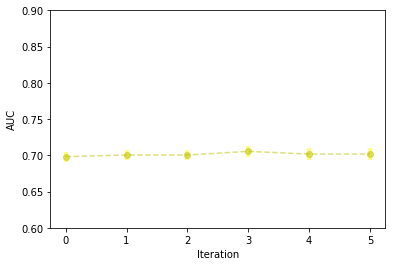

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# Add scores from experiment iterations
iteration_data = h2oai.list_model_iteration_data(experiment.key, 0, len(experiment.iteration_data))
iterations = list(map(lambda iteration: iteration.iteration, iteration_data))
scores_mean = list(map(lambda iteration: iteration.score_mean, iteration_data))
scores_sd = list(map(lambda iteration: iteration.score_sd, iteration_data))

# Add score from final ensemble
iterations = iterations + [max(iterations) + 1]
scores_mean = scores_mean + [experiment.valid_score]
scores_sd = scores_sd + [experiment.valid_score_sd]

plt.figure()
plt.errorbar(iterations, scores_mean, yerr=scores_sd, color = "y", 
             ecolor='yellow', fmt = '--o', elinewidth = 4, alpha = 0.5)
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.ylim([0.6, .9])
plt.show();

#### Download the test predictions ...

In [33]:
h2oai.download(src_path=experiment.test_predictions_path, dest_dir=".")

'./test_preds.csv'

In [34]:
test_preds = pd.read_csv("./test_preds.csv")
test_preds.head()

,loan_status.Charged Off,loan_status.Fully Paid
0,0.127741,0.872259
1,0.209393,0.790607
2,0.067872,0.932128
3,0.090275,0.909725
4,0.141584,0.858417


##### Notebook Created by: Karthik Guruswamy, Principal Solutions Architect/Customer Data Scientist, H2O.ai